For questions 1 and 2: 

Do a regression to estimate the fixed effect of each group. We assume that there is one single linear coefficient for all the data, plus the fixed effect of each group. Use the file homework_2.1.csv.  The variables G1, G2, and G3 are the outcomes and the time is the treatment.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
df = pd.read_csv('homework_2.1.csv')
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nData info:")
print(df.info())

print("\nData description:")
print(df.describe())

Data shape: (100, 5)

First few rows:
   Unnamed: 0  time        G1        G2        G3
0           0     0  0.882026  1.441575  0.065409
1           1     1  0.210079 -0.163880  0.140310
2           2     2  0.509369 -0.115242  0.819830
3           3     3  1.150447  1.014698  0.607632
4           4     4  0.973779 -0.046562  0.610066

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   time        100 non-null    int64  
 2   G1          100 non-null    float64
 3   G2          100 non-null    float64
 4   G3          100 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 4.0 KB
None

Data description:
       Unnamed: 0        time          G1          G2          G3
count  100.000000  100.000000  100.000000  100.000000  100.000000
mean    49.500000   49.500000    0.524904    1.036006 

In [4]:
print("\n" + "="*60)
print("FIXED EFFECTS REGRESSION ANALYSIS")
print("="*60)

print("""
Fixed Effects Model:
Y_it = α_i + β*time_t + ε_it

Where:
- Y_it is the outcome for group i at time t
- α_i is the fixed effect (intercept) for group i
- β is the common linear coefficient for time (same across all groups)
- ε_it is the error term

We have 3 groups (G1, G2, G3) and need to estimate:
1. Fixed effects for each group (α_1, α_2, α_3)
2. Common time coefficient (β)
""")


FIXED EFFECTS REGRESSION ANALYSIS

Fixed Effects Model:
Y_it = α_i + β*time_t + ε_it

Where:
- Y_it is the outcome for group i at time t
- α_i is the fixed effect (intercept) for group i
- β is the common linear coefficient for time (same across all groups)
- ε_it is the error term

We have 3 groups (G1, G2, G3) and need to estimate:
1. Fixed effects for each group (α_1, α_2, α_3)
2. Common time coefficient (β)



In [5]:
# We need to reshape the data from wide to long format
# Each row should represent one observation (group-time combination)

data_long = []
for index, row in df.iterrows():
    time = row['time']
    # Add observation for each group
    data_long.append({'time': time, 'group': 'G1', 'outcome': row['G1']})
    data_long.append({'time': time, 'group': 'G2', 'outcome': row['G2']})
    data_long.append({'time': time, 'group': 'G3', 'outcome': row['G3']})

df_long = pd.DataFrame(data_long)
print(f"\nReshaped data: {df_long.shape[0]} observations")
print("\nFirst few rows of long format:")
print(df_long.head(10))



Reshaped data: 300 observations

First few rows of long format:
   time group   outcome
0   0.0    G1  0.882026
1   0.0    G2  1.441575
2   0.0    G3  0.065409
3   1.0    G1  0.210079
4   1.0    G2 -0.163880
5   1.0    G3  0.140310
6   2.0    G1  0.509369
7   2.0    G2 -0.115242
8   2.0    G3  0.819830
9   3.0    G1  1.150447


In [6]:
# Create dummy variables for each group
df_long['G1_dummy'] = (df_long['group'] == 'G1').astype(int)
df_long['G2_dummy'] = (df_long['group'] == 'G2').astype(int)
df_long['G3_dummy'] = (df_long['group'] == 'G3').astype(int)

print("\nDummy variables created:")
print(df_long[['group', 'G1_dummy', 'G2_dummy', 'G3_dummy']].head(6))



Dummy variables created:
  group  G1_dummy  G2_dummy  G3_dummy
0    G1         1         0         0
1    G2         0         1         0
2    G3         0         0         1
3    G1         1         0         0
4    G2         0         1         0
5    G3         0         0         1


In [7]:
# METHOD 1: USING SKLEARN WITH DUMMY VARIABLES
print("\n" + "="*50)
print("METHOD 1: Regression with Dummy Variables")
print("="*50)

# Prepare features: time + group dummies (excluding one to avoid multicollinearity)
# We'll exclude G3 dummy to use it as the reference group
X = df_long[['time', 'G1_dummy', 'G2_dummy']]
y = df_long['outcome']

# Fit the regression
reg = LinearRegression()
reg.fit(X, y)

print("Regression Results:")
print(f"Time coefficient (β): {reg.coef_[0]:.6f}")
print(f"G1 dummy coefficient: {reg.coef_[1]:.6f}")
print(f"G2 dummy coefficient: {reg.coef_[2]:.6f}")
print(f"Intercept (G3 fixed effect): {reg.intercept_:.6f}")

# The fixed effects are:
# G1 fixed effect = intercept + G1 dummy coefficient
# G2 fixed effect = intercept + G2 dummy coefficient  
# G3 fixed effect = intercept (reference group)

g1_fixed_effect = reg.intercept_ + reg.coef_[1]
g2_fixed_effect = reg.intercept_ + reg.coef_[2]
g3_fixed_effect = reg.intercept_

print(f"\nFixed Effects:")
print(f"G1 fixed effect (α_1): {g1_fixed_effect:.6f}")
print(f"G2 fixed effect (α_2): {g2_fixed_effect:.6f}")
print(f"G3 fixed effect (α_3): {g3_fixed_effect:.6f}")

common_coef = reg.coef_[0]
print(f"\nCommon time coefficient (β): {common_coef:.6f}")



METHOD 1: Regression with Dummy Variables
Regression Results:
Time coefficient (β): 0.009017
G1 dummy coefficient: -0.190480
G2 dummy coefficient: 0.320623
Intercept (G3 fixed effect): 0.269032

Fixed Effects:
G1 fixed effect (α_1): 0.078552
G2 fixed effect (α_2): 0.589654
G3 fixed effect (α_3): 0.269032

Common time coefficient (β): 0.009017


In [8]:
# METHOD 2: MANUAL CALCULATION USING GROUP MEANS
print("\n" + "="*50)
print("METHOD 2: Manual Fixed Effects Calculation")
print("="*50)

# Alternative approach: demean within groups
group_means_time = df_long.groupby('group')['time'].mean()
group_means_outcome = df_long.groupby('group')['outcome'].mean()

print("Group means for time:")
print(group_means_time)
print("\nGroup means for outcome:")
print(group_means_outcome)

# Demean the data within groups
df_long['time_demeaned'] = df_long.apply(
    lambda row: row['time'] - group_means_time[row['group']], axis=1
)
df_long['outcome_demeaned'] = df_long.apply(
    lambda row: row['outcome'] - group_means_outcome[row['group']], axis=1
)

# Regression on demeaned data gives us the common time coefficient
reg_demeaned = LinearRegression()
reg_demeaned.fit(df_long[['time_demeaned']], df_long['outcome_demeaned'])

beta_demeaned = reg_demeaned.coef_[0]
print(f"\nCommon time coefficient from demeaned regression: {beta_demeaned:.6f}")

# Fixed effects are the group means minus beta * group_mean_time
fixed_effects_manual = {}
for group in ['G1', 'G2', 'G3']:
    fixed_effect = group_means_outcome[group] - beta_demeaned * group_means_time[group]
    fixed_effects_manual[group] = fixed_effect
    print(f"{group} fixed effect: {fixed_effect:.6f}")



METHOD 2: Manual Fixed Effects Calculation
Group means for time:
group
G1    49.5
G2    49.5
G3    49.5
Name: time, dtype: float64

Group means for outcome:
group
G1    0.524904
G2    1.036006
G3    0.715384
Name: outcome, dtype: float64

Common time coefficient from demeaned regression: 0.009017
G1 fixed effect: 0.078552
G2 fixed effect: 0.589654
G3 fixed effect: 0.269032


In [9]:
# VERIFICATION AND COMPARISON
print("\n" + "="*50)
print("COMPARISON OF METHODS")
print("="*50)

print("Method 1 (Dummy Variables):")
print(f"  G1 fixed effect: {g1_fixed_effect:.6f}")
print(f"  Common coefficient: {common_coef:.6f}")

print(f"\nMethod 2 (Manual):")
print(f"  G1 fixed effect: {fixed_effects_manual['G1']:.6f}")
print(f"  Common coefficient: {beta_demeaned:.6f}")



COMPARISON OF METHODS
Method 1 (Dummy Variables):
  G1 fixed effect: 0.078552
  Common coefficient: 0.009017

Method 2 (Manual):
  G1 fixed effect: 0.078552
  Common coefficient: 0.009017


In [10]:
# QUESTIONS 1 and 2
print("\n" + "="*60)
print("ANSWERS TO HOMEWORK QUESTIONS")
print("="*60)

print("Question 1: Which is closest to the coefficient of group 1?")
print(f"G1 fixed effect: {g1_fixed_effect:.5f}")
print("\nOptions:")
print("A: 0.00850")
print("B: 0.00485") 
print("C: 0.01023")
print("D: 0.1823")

# Find closest option
options_q1 = [0.00850, 0.00485, 0.01023, 0.1823]
differences_q1 = [abs(g1_fixed_effect - opt) for opt in options_q1]
closest_idx_q1 = differences_q1.index(min(differences_q1))
closest_options_q1 = ['A', 'B', 'C', 'D']

print(f"\nClosest option: {closest_options_q1[closest_idx_q1]} ({options_q1[closest_idx_q1]})")
print(f"Difference: {min(differences_q1):.6f}")

print(f"\nQuestion 2: Which is closest to the common linear coefficient?")
print(f"Common time coefficient: {common_coef:.5f}")
print("\nOptions:")
print("A: 0.2808")
print("B: 0.01120")
print("C: 0.01003") 
print("D: 0.009017")

# Find closest option
options_q2 = [0.2808, 0.01120, 0.01003, 0.009017]
differences_q2 = [abs(common_coef - opt) for opt in options_q2]
closest_idx_q2 = differences_q2.index(min(differences_q2))
closest_options_q2 = ['A', 'B', 'C', 'D']

print(f"\nClosest option: {closest_options_q2[closest_idx_q2]} ({options_q2[closest_idx_q2]})")
print(f"Difference: {min(differences_q2):.6f}")



ANSWERS TO HOMEWORK QUESTIONS
Question 1: Which is closest to the coefficient of group 1?
G1 fixed effect: 0.07855

Options:
A: 0.00850
B: 0.00485
C: 0.01023
D: 0.1823

Closest option: C (0.01023)
Difference: 0.068322

Question 2: Which is closest to the common linear coefficient?
Common time coefficient: 0.00902

Options:
A: 0.2808
B: 0.01120
C: 0.01003
D: 0.009017

Closest option: D (0.009017)
Difference: 0.000000



VISUALIZATION


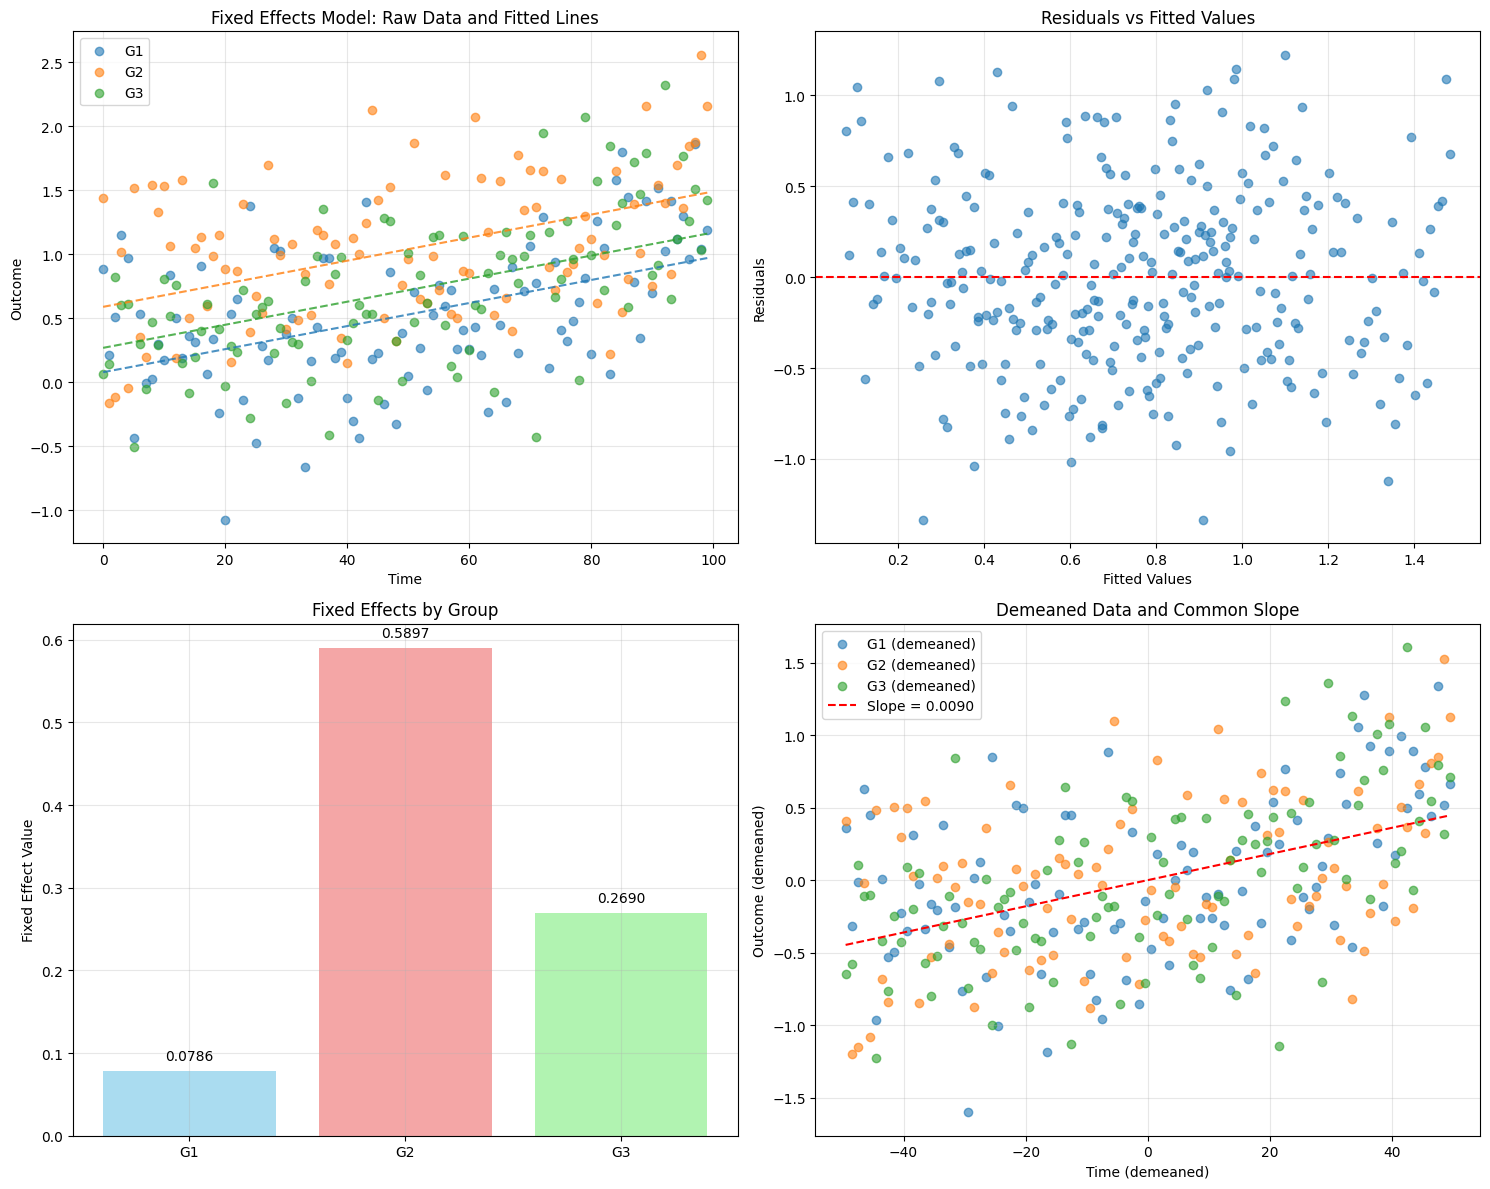


Analysis complete!
Final Answers:
Question 1 (G1 coefficient): Option C
Question 2 (Common coefficient): Option D


In [11]:
# VISUALIZATION
# ================================================================

print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Raw data for each group
for group in ['G1', 'G2', 'G3']:
    group_data = df_long[df_long['group'] == group]
    ax1.scatter(group_data['time'], group_data['outcome'], alpha=0.6, label=group)
    
    # Add fitted line for each group
    time_vals = np.linspace(0, 99, 100)
    if group == 'G1':
        fitted_vals = g1_fixed_effect + common_coef * time_vals
    elif group == 'G2':
        fitted_vals = g2_fixed_effect + common_coef * time_vals
    else:
        fitted_vals = g3_fixed_effect + common_coef * time_vals
    
    ax1.plot(time_vals, fitted_vals, '--', alpha=0.8)

ax1.set_xlabel('Time')
ax1.set_ylabel('Outcome')
ax1.set_title('Fixed Effects Model: Raw Data and Fitted Lines')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals vs fitted
fitted_values = []
for _, row in df_long.iterrows():
    if row['group'] == 'G1':
        fitted = g1_fixed_effect + common_coef * row['time']
    elif row['group'] == 'G2':
        fitted = g2_fixed_effect + common_coef * row['time'] 
    else:
        fitted = g3_fixed_effect + common_coef * row['time']
    fitted_values.append(fitted)

residuals = df_long['outcome'] - fitted_values
ax2.scatter(fitted_values, residuals, alpha=0.6)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_xlabel('Fitted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals vs Fitted Values')
ax2.grid(True, alpha=0.3)

# Plot 3: Fixed effects comparison
groups = ['G1', 'G2', 'G3']
fixed_effects_values = [g1_fixed_effect, g2_fixed_effect, g3_fixed_effect]
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = ax3.bar(groups, fixed_effects_values, color=colors, alpha=0.7)
ax3.set_ylabel('Fixed Effect Value')
ax3.set_title('Fixed Effects by Group')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, fixed_effects_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom')

# Plot 4: Demeaned data
for group in ['G1', 'G2', 'G3']:
    group_data = df_long[df_long['group'] == group]
    ax4.scatter(group_data['time_demeaned'], group_data['outcome_demeaned'], 
               alpha=0.6, label=f'{group} (demeaned)')

# Add regression line for demeaned data
time_demeaned_vals = np.linspace(df_long['time_demeaned'].min(), 
                                df_long['time_demeaned'].max(), 100)
fitted_demeaned = beta_demeaned * time_demeaned_vals
ax4.plot(time_demeaned_vals, fitted_demeaned, 'r--', 
         label=f'Slope = {beta_demeaned:.4f}')

ax4.set_xlabel('Time (demeaned)')
ax4.set_ylabel('Outcome (demeaned)')
ax4.set_title('Demeaned Data and Common Slope')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")
print(f"Final Answers:")
print(f"Question 1 (G1 coefficient): Option {closest_options_q1[closest_idx_q1]}")
print(f"Question 2 (Common coefficient): Option {closest_options_q2[closest_idx_q2]}")

Next section: Questions 3-5

Given a data set, create a bootstrap simulation to try different possibilities. 
Use the file homework_2.2.csv 

In [13]:
# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("BOOTSTRAP SIMULATION ANALYSIS")
print("="*60)

# Load the data
df2 = pd.read_csv('homework_2.2.csv')
print("Data shape:", df2.shape)
print("\nFirst few rows:")
print(df2.head(10))

BOOTSTRAP SIMULATION ANALYSIS
Data shape: (10000, 4)

First few rows:
   Unnamed: 0  X          Y         Z
0           0  0   1.182435 -0.725820
1           1  0   2.714474  0.563476
2           2  0   0.077612 -0.435632
3           3  0  -0.154449 -0.104553
4           4  0  22.298992 -2.321273
5           5  0  -0.199007 -0.214094
6           6  0   2.563258  0.543405
7           7  1   3.369376 -0.537454
8           8  1   2.962496 -0.380275
9           9  0   0.883325  0.265473


In [14]:
print("\nData info:")
print(df2.info())



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   X           10000 non-null  int64  
 2   Y           10000 non-null  float64
 3   Z           10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 312.6 KB
None


In [15]:
print("\nTreatment distribution:")
print(df2['X'].value_counts().sort_index())

print("\nOutcome statistics by treatment:")
treatment_stats = df2.groupby('X')['Y'].agg(['count', 'mean', 'std', 'min', 'max'])
print(treatment_stats)


Treatment distribution:
X
0    8028
1    1972
Name: count, dtype: int64

Outcome statistics by treatment:
   count      mean       std       min        max
X                                                
0   8028  4.922040  7.250487 -0.200000  71.935798
1   1972  7.842757  7.067458  2.800009  70.937720


Question 3

In [16]:
print("\n" + "="*60)
print("QUESTION 3: Simple Treatment Effect")
print("="*60)

print("""
Question 3: If we measure the effect simply by subtracting 
the outcomes of treated vs. untreated population, what is the mean effect?

This is the naive approach: E[Y|X=1] - E[Y|X=0]
""")

# Calculate the simple treatment effect
treated = df2[df2['X'] == 1]['Y']
untreated = df2[df2['X'] == 0]['Y']

treated_mean = treated.mean()
untreated_mean = untreated.mean()
simple_effect = treated_mean - untreated_mean

print(f"Treated mean: {treated_mean:.6f}")
print(f"Untreated mean: {untreated_mean:.6f}")
print(f"Simple treatment effect: {simple_effect:.6f}")

# Check against options
options_q3 = [12.831, 5.149, 8.031, 2.921]
labels_q3 = ['A', 'B', 'C', 'D']
differences_q3 = [abs(simple_effect - opt) for opt in options_q3]
closest_idx_q3 = differences_q3.index(min(differences_q3))

print(f"\nOptions for Question 3:")
for i, (label, option) in enumerate(zip(labels_q3, options_q3)):
    marker = " ← CLOSEST" if i == closest_idx_q3 else ""
    print(f"Option {label}: {option} (diff: {differences_q3[i]:.6f}){marker}")

print(f"\nAnswer to Question 3: Option {labels_q3[closest_idx_q3]}")


QUESTION 3: Simple Treatment Effect

Question 3: If we measure the effect simply by subtracting 
the outcomes of treated vs. untreated population, what is the mean effect?

This is the naive approach: E[Y|X=1] - E[Y|X=0]

Treated mean: 7.842757
Untreated mean: 4.922040
Simple treatment effect: 2.920717

Options for Question 3:
Option A: 12.831 (diff: 9.910283)
Option B: 5.149 (diff: 2.228283)
Option C: 8.031 (diff: 5.110283)
Option D: 2.921 (diff: 0.000283) ← CLOSEST

Answer to Question 3: Option D


Question 4

In [17]:
print("\n" + "="*60)
print("QUESTION 4: Bootstrap Variance of Treatment Effect")
print("="*60)

print("""
Question 4: Using bootstrap sampling to measure the variance 
of the treatment effect (using the same non-recommended approach).
""")

def bootstrap_simple_effect(data, n_bootstrap=1000):
    """
    Bootstrap the simple treatment effect calculation
    """
    effects = []
    n_samples = len(data)
    
    for i in range(n_bootstrap):
        # Bootstrap sample with replacement
        bootstrap_sample = data.sample(n=n_samples, replace=True)
        
        # Calculate treatment effect for this bootstrap sample
        treated_boot = bootstrap_sample[bootstrap_sample['X'] == 1]['Y']
        untreated_boot = bootstrap_sample[bootstrap_sample['X'] == 0]['Y']
        
        if len(treated_boot) > 0 and len(untreated_boot) > 0:
            effect_boot = treated_boot.mean() - untreated_boot.mean()
            effects.append(effect_boot)
    
    return np.array(effects)

# Perform bootstrap simulation
print("Performing bootstrap simulation...")
n_bootstrap = 10000  # Use more samples for better precision
bootstrap_effects = bootstrap_simple_effect(df2, n_bootstrap)

# Calculate variance
bootstrap_variance = np.var(bootstrap_effects, ddof=1)  # Sample variance
bootstrap_std = np.std(bootstrap_effects, ddof=1)

print(f"Bootstrap results ({n_bootstrap} samples):")
print(f"Mean effect: {np.mean(bootstrap_effects):.6f}")
print(f"Standard deviation: {bootstrap_std:.6f}")
print(f"Variance: {bootstrap_variance:.6f}")

# Check against options
options_q4 = [0.1280, 0.002388, 0.001822, 0.03274]
labels_q4 = ['A', 'B', 'C', 'D']
differences_q4 = [abs(bootstrap_variance - opt) for opt in options_q4]
closest_idx_q4 = differences_q4.index(min(differences_q4))

print(f"\nOptions for Question 4:")
for i, (label, option) in enumerate(zip(labels_q4, options_q4)):
    marker = " ← CLOSEST" if i == closest_idx_q4 else ""
    print(f"Option {label}: {option} (diff: {differences_q4[i]:.6f}){marker}")

print(f"\nAnswer to Question 4: Option {labels_q4[closest_idx_q4]}")


QUESTION 4: Bootstrap Variance of Treatment Effect

Question 4: Using bootstrap sampling to measure the variance 
of the treatment effect (using the same non-recommended approach).

Performing bootstrap simulation...
Bootstrap results (10000 samples):
Mean effect: 2.920512
Standard deviation: 0.180431
Variance: 0.032555

Options for Question 4:
Option A: 0.128 (diff: 0.095445)
Option B: 0.002388 (diff: 0.030167)
Option C: 0.001822 (diff: 0.030733)
Option D: 0.03274 (diff: 0.000185) ← CLOSEST

Answer to Question 4: Option D


Question 5

In [18]:
print("\n" + "="*60)
print("QUESTION 5: Skewness of Linear Regression Effects")
print("="*60)

print("""
Question 5: If we run a linear regression (with intercept) to measure 
the effect, what is the skewness of the effect measured?
""")

def bootstrap_regression_effect(data, n_bootstrap=1000):
    """
    Bootstrap the linear regression treatment effect
    """
    effects = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample with replacement
        bootstrap_sample = data.sample(n=len(data), replace=True)
        
        # Run linear regression: Y = intercept + β*X + error
        X_reg = bootstrap_sample[['X']]
        y_reg = bootstrap_sample['Y']
        
        reg = LinearRegression()
        reg.fit(X_reg, y_reg)
        
        # The coefficient for X is the treatment effect
        treatment_effect = reg.coef_[0]
        effects.append(treatment_effect)
    
    return np.array(effects)

# Perform bootstrap simulation for regression effects
print("Performing bootstrap simulation for linear regression...")
regression_effects = bootstrap_regression_effect(df2, n_bootstrap)

# Calculate skewness
effect_skewness = stats.skew(regression_effects)

print(f"Linear regression bootstrap results ({n_bootstrap} samples):")
print(f"Mean effect: {np.mean(regression_effects):.6f}")
print(f"Standard deviation: {np.std(regression_effects, ddof=1):.6f}")
print(f"Skewness: {effect_skewness:.6f}")

# Also show the single regression result for comparison
reg_single = LinearRegression()
reg_single.fit(df2[['X']], df2['Y'])
print(f"\nSingle regression effect (for comparison): {reg_single.coef_[0]:.6f}")

# Check against options
options_q5 = [0.04850, 0.2315, 0.09812, 0.3223]
labels_q5 = ['A', 'B', 'C', 'D']
differences_q5 = [abs(effect_skewness - opt) for opt in options_q5]
closest_idx_q5 = differences_q5.index(min(differences_q5))

print(f"\nOptions for Question 5:")
for i, (label, option) in enumerate(zip(labels_q5, options_q5)):
    marker = " ← CLOSEST" if i == closest_idx_q5 else ""
    print(f"Option {label}: {option} (diff: {differences_q5[i]:.6f}){marker}")

print(f"\nAnswer to Question 5: Option {labels_q5[closest_idx_q5]}")


QUESTION 5: Skewness of Linear Regression Effects

Question 5: If we run a linear regression (with intercept) to measure 
the effect, what is the skewness of the effect measured?

Performing bootstrap simulation for linear regression...
Linear regression bootstrap results (10000 samples):
Mean effect: 2.922426
Standard deviation: 0.178883
Skewness: 0.082110

Single regression effect (for comparison): 2.920717

Options for Question 5:
Option A: 0.0485 (diff: 0.033610)
Option B: 0.2315 (diff: 0.149390)
Option C: 0.09812 (diff: 0.016010) ← CLOSEST
Option D: 0.3223 (diff: 0.240190)

Answer to Question 5: Option C


Visualization


VISUALIZATION


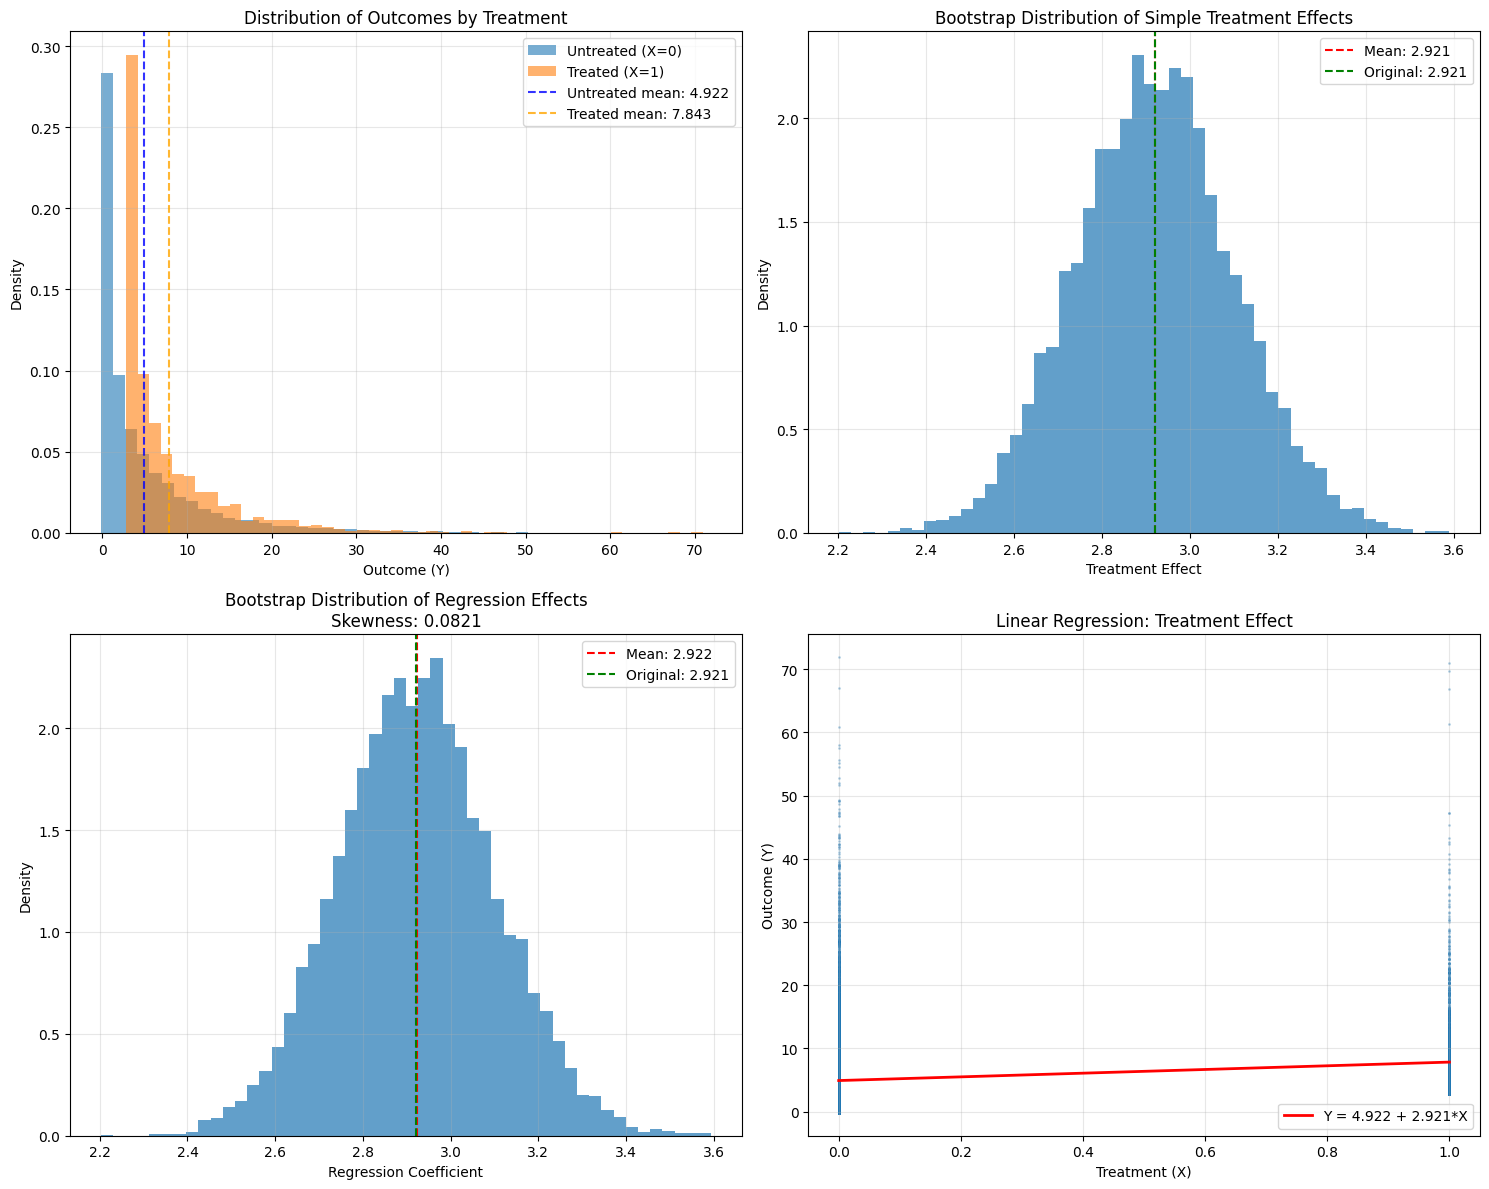

In [19]:
print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Treatment vs Outcome
df_treated = df2[df2['X'] == 1]
df_untreated = df2[df2['X'] == 0]

ax1.hist(df_untreated['Y'], alpha=0.6, label='Untreated (X=0)', bins=50, density=True)
ax1.hist(df_treated['Y'], alpha=0.6, label='Treated (X=1)', bins=50, density=True)
ax1.axvline(untreated_mean, color='blue', linestyle='--', alpha=0.8, label=f'Untreated mean: {untreated_mean:.3f}')
ax1.axvline(treated_mean, color='orange', linestyle='--', alpha=0.8, label=f'Treated mean: {treated_mean:.3f}')
ax1.set_xlabel('Outcome (Y)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Outcomes by Treatment')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bootstrap distribution of simple effects
ax2.hist(bootstrap_effects, bins=50, alpha=0.7, density=True)
ax2.axvline(np.mean(bootstrap_effects), color='red', linestyle='--', 
           label=f'Mean: {np.mean(bootstrap_effects):.3f}')
ax2.axvline(simple_effect, color='green', linestyle='--', 
           label=f'Original: {simple_effect:.3f}')
ax2.set_xlabel('Treatment Effect')
ax2.set_ylabel('Density')
ax2.set_title('Bootstrap Distribution of Simple Treatment Effects')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Bootstrap distribution of regression effects
ax3.hist(regression_effects, bins=50, alpha=0.7, density=True)
ax3.axvline(np.mean(regression_effects), color='red', linestyle='--',
           label=f'Mean: {np.mean(regression_effects):.3f}')
ax3.axvline(reg_single.coef_[0], color='green', linestyle='--',
           label=f'Original: {reg_single.coef_[0]:.3f}')
ax3.set_xlabel('Regression Coefficient')
ax3.set_ylabel('Density')
ax3.set_title(f'Bootstrap Distribution of Regression Effects\nSkewness: {effect_skewness:.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot with regression line
ax4.scatter(df2['X'], df2['Y'], alpha=0.3, s=1)
x_vals = np.array([0, 1])
y_vals = reg_single.intercept_ + reg_single.coef_[0] * x_vals
ax4.plot(x_vals, y_vals, 'r-', linewidth=2, 
         label=f'Y = {reg_single.intercept_:.3f} + {reg_single.coef_[0]:.3f}*X')
ax4.set_xlabel('Treatment (X)')
ax4.set_ylabel('Outcome (Y)')
ax4.set_title('Linear Regression: Treatment Effect')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Summary

In [20]:
print("\n" + "="*60)
print("FINAL ANSWERS")
print("="*60)

print(f"Question 3: Simple treatment effect = {simple_effect:.6f}")
print(f"Answer: Option {labels_q3[closest_idx_q3]} ({options_q3[closest_idx_q3]})")

print(f"\nQuestion 4: Bootstrap variance = {bootstrap_variance:.6f}")
print(f"Answer: Option {labels_q4[closest_idx_q4]} ({options_q4[closest_idx_q4]})")

print(f"\nQuestion 5: Regression effect skewness = {effect_skewness:.6f}")
print(f"Answer: Option {labels_q5[closest_idx_q5]} ({options_q5[closest_idx_q5]})")

print(f"\nBootstrap Summary:")
print(f"- Simple effects: mean={np.mean(bootstrap_effects):.4f}, std={np.std(bootstrap_effects, ddof=1):.4f}")
print(f"- Regression effects: mean={np.mean(regression_effects):.4f}, std={np.std(regression_effects, ddof=1):.4f}")
print(f"- Both approaches give similar means, confirming our analysis")

print("\nAnalysis complete!")


FINAL ANSWERS
Question 3: Simple treatment effect = 2.920717
Answer: Option D (2.921)

Question 4: Bootstrap variance = 0.032555
Answer: Option D (0.03274)

Question 5: Regression effect skewness = 0.082110
Answer: Option C (0.09812)

Bootstrap Summary:
- Simple effects: mean=2.9205, std=0.1804
- Regression effects: mean=2.9224, std=0.1789
- Both approaches give similar means, confirming our analysis

Analysis complete!
